___
# **Parameter Estimation for Ion Exchange**
___


This demonstration will present the steps for setting up and conducting a parameter estimation for the WaterTAP ion exchange (IX) model. This tutorial will go through the steps to fit the IX model to breakthrough data for PFAS species. 

## Model Equations

The [WaterTAP IX model](https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/ion_exchange_0D.html) we will be using is an implementation of the Clark model. This model includes three parameters related to the bed capacity, equilibrium, and mass transfer of the solute of interest on to the media. The governing equation is shown below.

$$
\frac{\textcolor{red}{C_b}}{\textcolor{red}{C_0}} =
\frac{1}{\left( 1 +
\left(2^{\textcolor{RoyalBlue}{n} - 1} - 1\right)
\exp\left[
\frac{\textcolor{RoyalBlue}{k_T} Z (\textcolor{RoyalBlue}{n} - 1)}
{\textcolor{RoyalBlue}{BV_{50}} \, u_{bed}}
\left(\textcolor{RoyalBlue}{BV_{50}} - \textcolor{green}{BV}\right)
\right]
\right)^{\tfrac{1}{\textcolor{RoyalBlue}{n} - 1}}}
$$

<!-- **Color Legend:**   -->
- $u_{bed}$ = bed loading rate, adopted from pilot experiments
- $Z$ = bed depth, adopted from pilot experiments
- $\textcolor{red}{C_b/C_0}$ = Effluent concentration ratio, determined from pilot experiments
- $\textcolor{green}{BV}$ = Bed volumes treated, determined from pilot experiments
- $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ = Clark model parameters to be fit with parameter estimation

In essence, we want to estimate the values for $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ to know the $\textcolor{green}{BV}$ that the relative effluent concentration is $\textcolor{red}{ C_b/C_0}$. 


___
## **Part 1 - Solve Parameter Estimation with Breakthrough Data**
### **1.1 Import required modules**
Import all Pyomo, WaterTAP and helper modules needed for building and solving the parameter estimation problem.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyomo.contrib.parmest.parmest as parmest
from pyomo.environ import (
    ConcreteModel,
    value,
    assert_optimal_termination,
    units as pyunits,
)
from idaes.core import FlowsheetBlock
import idaes.core.util.scaling as iscale
from idaes.core.util.model_statistics import degrees_of_freedom

from watertap.core.solvers import get_solver
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock
from watertap.unit_models.ion_exchange_0D import IonExchange0D

solver = get_solver()

### **1.2 Gather and prepare the data**
*How does data need to be formatted for parmest?*


- **Pandas Dataframe:** each column is an observed quantity (temperature, concentration, vapor pressure, etc.), each row is a distinct scenario (25, 0.02, 31.33)

**Other options:**
- **List of dictionaries:** each entry of the list is a distinct scenario, each key an observed quantity 
- **List of json file names:** each entry of the list contains a json file with the distinct scenario (for large datasets in parallel computing)

In this tutorial, we use the data collected from a pilot plant from **Orange County Water District (OCWD)** for treating PFAS with IX.

,bv,cb,species,resin,c0,c_norm,curve_id
0,15131.51332,0.044226,PFOA,a694e,15.8,0.002799,1
1,56630.53237,0.060187,PFOA,a694e,15.8,0.003809,1
2,69166.69438,0.065008,PFOA,a694e,15.8,0.004114,1
3,77002.62694,1.971868,PFOA,a694e,15.8,0.124802,1
4,85257.53999,3.417351,PFOA,a694e,15.8,0.216288,1
5,103017.65700,4.693413,PFOA,a694e,15.8,0.297051,1
6,109548.43210,6.311309,PFOA,a694e,15.8,0.399450,1
7,135124.53030,8.801915,PFOA,a694e,15.8,0.557083,1
8,152490.60620,11.404748,PFOA,a694e,15.8,0.721820,1
9,178060.05390,13.664583,PFOA,a694e,15.8,0.864847,1


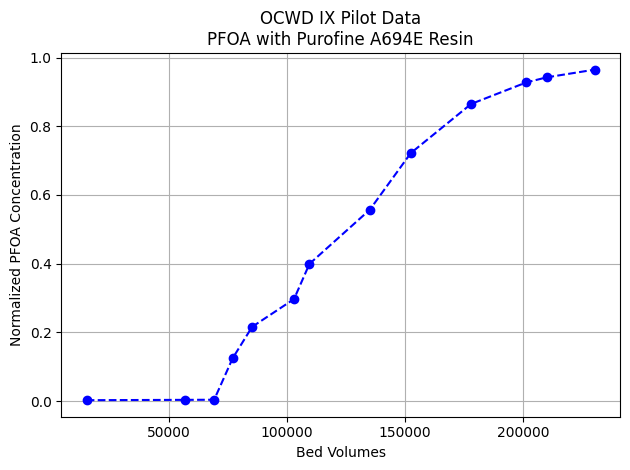

In [2]:
# Read in all data
all_data = pd.read_csv("breakthrough_data.csv")

# Use data from first curve only
data = all_data[all_data.curve_id == 1].copy()

fig, ax = plt.subplots()
ax.plot(data["bv"], data["c_norm"], marker="o", color="blue", ls="--")
ax.set_xlabel("Bed Volumes")
ax.set_ylabel("Normalized PFOA Concentration")
ax.set_title(f"OCWD IX Pilot Data\nPFOA with Purofine A694E Resin")
ax.grid(visible=True)
fig.tight_layout()

data

In [14]:
def ix_parmest(data):
    """
    Build for OCWD IX Pilot System
    """
    
    # Pilot system parameters
    bed_depth = 29 * pyunits.inch
    bed_vol = 95.44 * pyunits.inches**3
    col_diam = 2.05 * pyunits.inch
    flow_rate = 0.2 * pyunits.gallon / pyunits.minute
    ebct = 2.07 * pyunits.minute
    # Using Purofine PFA694 resin properties
    resin_dens = 720 * pyunits.kg / pyunits.m**3
    resin_diam = 0.000675 * pyunits.m

    # Inlet conditions
    species = "PFOA"
    c0 = 15.8 * pyunits.ng / pyunits.L
    mw = 0.41407 * pyunits.kg / pyunits.mol

    ion_props = {
        "solute_list": [species],
        "mw_data": {"H2O": 0.018, species: 0.41407},
        "molar_volume_data": {("Liq", species): 0.000272},
        "diffus_calculation": "HaydukLaudie",
        "charge": {species: -1},
    }

    # Build model
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = MCASParameterBlock(**ion_props)

    # Add IX model
    ix_config = {
        "property_package": m.fs.properties,
        "target_ion": species,
        # Use Freundlich isotherm for Clark model
        "isotherm": "freundlich",
        "regenerant": "single_use",
    }
    m.fs.ix = ix = IonExchange0D(**ix_config)

    # Set feed conditions
    pfas_mol_flow = pyunits.convert(
        c0 / mw * flow_rate, to_units=pyunits.mol / pyunits.s
    )
    h2o_mol_flow = 55.5 * pyunits.mol / pyunits.liter * flow_rate
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", "H2O"].fix(h2o_mol_flow)
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", species].fix(
        pfas_mol_flow
    )
    ix.process_flow.properties_in[0].pressure.fix(101325)
    ix.process_flow.properties_in[0].temperature.fix(298)

    # Adjust bounds for pilot system and parameter estimation
    ix.bed_depth.setlb(0)
    ix.bed_vol_tot.setub(bed_vol * 1.001)
    ix.col_diam.setlb(0)
    ix.ebct.setlb(0)
    ix.vel_bed.setlb(0)
    ix.vel_bed.setub(1)
    ix.freundlich_n.setlb(1.05)
    ix.freundlich_n.setub(100)
    ix.col_height_to_diam_ratio.setlb(0)

    # Fix known parameters
    ix.col_diam.set_value(col_diam)
    ix.resin_bulk_dens.fix(resin_dens)
    ix.resin_diam.fix(resin_diam)
    ix.bed_depth.fix(bed_depth)
    ix.ebct.fix(ebct)
    ix.number_columns.fix(1)
    ix.c_norm.fix(0.5)

    # Deactivate steady-state constraints
    # We don't need these for parameter estimation
    ix.eq_c_traps.deactivate()
    ix.c_traps.fix()
    ix.eq_tb_traps.deactivate()
    ix.tb_traps.fix()
    ix.eq_traps.deactivate()
    ix.traps.fix()
    ix.eq_c_norm_avg.deactivate()
    ix.c_norm_avg.fix(1e-3)
    ix.process_flow.mass_transfer_term.fix(0)

    # Initial guess for parameters to be estimated
    ix.bv_50.fix(120000)
    ix.mass_transfer_coeff.fix(0.2)
    ix.freundlich_n.fix(2.0)

    # Scale model
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1 / value(h2o_mol_flow), index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp",
        1 / value(pfas_mol_flow),
        index=("Liq", species),
    )

    iscale.set_scaling_factor(ix.bed_vol_tot, 1e4)
    iscale.calculate_scaling_factors(m)

    # Solve at initial point
    assert degrees_of_freedom(m) == 0
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)

    # Set conditions from data
    ix.c_norm.fix(data.iloc[0]["c_norm"])
    # print(f"Running with c_norm = {value(ix.c_norm[species])}")
    assert degrees_of_freedom(m) == 0
    m.fs.ix.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)

    return m


m = ix_parmest(data)
data

2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 1b Complete.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 1c Complete.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Complete: optimal - Optimal Solution Found
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 1b Complete.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 1c Complete.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 13:33:49 [INFO] idaes.init.fs.ix: Initialization Complete: optimal - Optimal Solution Found


,bv,cb,species,resin,c0,c_norm,curve_id
0,15131.51332,0.044226,PFOA,a694e,15.8,0.002799,1
1,56630.53237,0.060187,PFOA,a694e,15.8,0.003809,1
2,69166.69438,0.065008,PFOA,a694e,15.8,0.004114,1
3,77002.62694,1.971868,PFOA,a694e,15.8,0.124802,1
4,85257.53999,3.417351,PFOA,a694e,15.8,0.216288,1
5,103017.65700,4.693413,PFOA,a694e,15.8,0.297051,1
6,109548.43210,6.311309,PFOA,a694e,15.8,0.399450,1
7,135124.53030,8.801915,PFOA,a694e,15.8,0.557083,1
8,152490.60620,11.404748,PFOA,a694e,15.8,0.721820,1
9,178060.05390,13.664583,PFOA,a694e,15.8,0.864847,1


In [15]:
theta_names = ["fs.ix.bv_50", "fs.ix.mass_transfer_coeff", "fs.ix.freundlich_n"]

In [16]:
def SSE(m, data):
    expr = (float(data.iloc[0]["bv"]) - m.fs.ix.bv) ** 2
    return expr

In [17]:
pest = parmest.Estimator(ix_parmest, data, theta_names, SSE, tee=False)

In [18]:
# Solve the parameter estimation problem
obj, theta = pest.theta_est()

# Display results
print("theta:\n", theta)

2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 1b Complete.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 1c Complete.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Complete: optimal - Optimal Solution Found
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 1b Complete.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 1c Complete.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Complete: optimal - Optimal Solution Found
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:54 [INFO] idaes.init.fs.ix: I

2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 1b Complete.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 1c Complete.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Complete: optimal - Optimal Solution Found
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 1b Complete.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 1c Complete.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Complete: optimal - Optimal Solution Found
dof = 0
2026-01-14 13:33:03 [INFO] idaes.init.fs.ix: Initialization Step 1a Complete.
2026-01-14 13:33:03 [INFO] idaes.init.

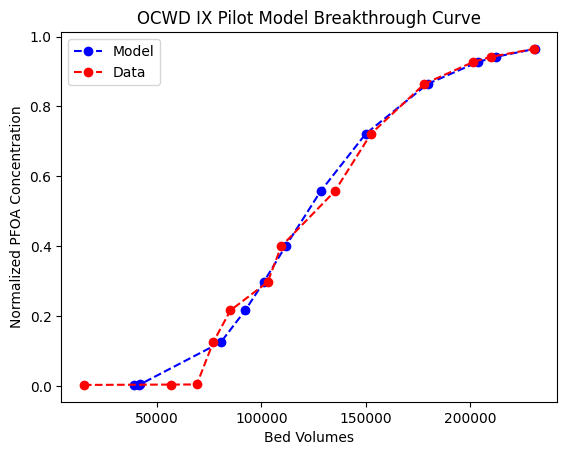

In [12]:
m = ix_parmest(data)

for k, v in theta.items():
    var = m.find_component(k)
    var.fix(v)
print(f"dof = {degrees_of_freedom(m)}")
m.fs.ix.initialize()

tbs = []
bvs = []
xs = data.c_norm.tolist()
for x in xs:
    m.fs.ix.c_norm.fix(x)
    m.fs.ix.initialize()
    print(f"c_norm = {x}")
    print(f"tb = {value(m.fs.ix.t_breakthru)}")
    print(f"dof = {degrees_of_freedom(m)}")
    results = solver.solve(m)
    assert_optimal_termination(results)
    tbs.append(value(m.fs.ix.t_breakthru))
    bvs.append(value(m.fs.ix.bv))

fig, ax = plt.subplots()
ax.plot(bvs, xs, marker="o", color="blue", ls="--", label="Model")

ax.plot(data["bv"], data["c_norm"], marker="o", color="red", ls="--", label="Data")
ax.set_ylabel("Normalized PFOA Concentration")
ax.set_xlabel("Bed Volumes")
ax.set_title("OCWD IX Pilot Model Breakthrough Curve")
ax.legend()